In [1]:
import numpy as np

from keras import layers, models

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_1x1_1 (Conv2D)           (None, 224, 224, 32) 128         input_19[0][0]                   
__________________________________________________________________________________________________
block1_1x1_3 (Conv2D)           (None, 224, 224, 32) 128         input_19[0][0]                   
__________________________________________________________________________________________________
block1_1x1_5 (Conv2D)           (None, 224, 224, 32) 128         input_19[0][0]                   
__________________________________________________________________________________________________
block1_dil

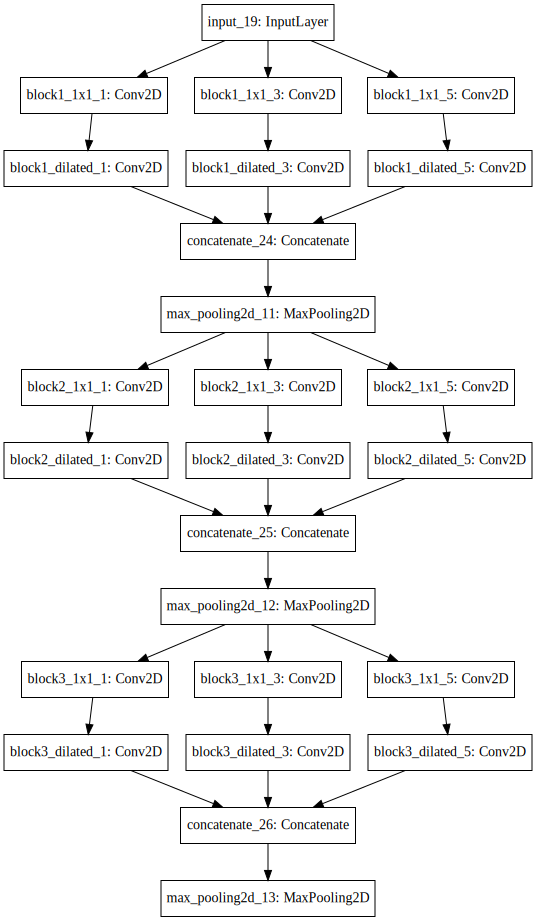

In [24]:
def dilation_block(x, branches, in_filters, out_filters, activation='relu', 
                   batch_norm=True, pool_size=None, name='block'):
    '''Block with branches defined by dilation rates.
    
    Parameters
    ----------
    x : Tensor, BxHxWxC
        input Tensor
    branches : iterable(int)
        Each item defines a branch with dilation_rate=item
    in_filters : iterable or int
        Output filters for 1x1 reduction, per branch.
        If iterable, must have len == len(branches). If int, assumed all branches the same.
    out_filters : iter
        Output filters for 3x3 dilated conv, per branch.
        If iterable, must have len == len(branches). If int, assumed all branches the same.
    activation : str, optional
        Activation function, default='relu'.
    batch_norm : bool, optional
        Whether to add terminal BatchNorm layers, default=`True`.
    pool_size : tuple(int), or `None`
        If not `None`, passed to MaxPool2D on block output.
    name : str, optional
        Base name for block/branch layer names
        
    Returns
    -------
    The output of passing `x` through the constructed block.
    '''
    
    args = [branches, in_filters, out_filters]
    if all([hasattr(f, '__iter__') for f in args]):
        print([lambda f: hasattr(f, '__iter__') for f in args])
        assert len(set([len(x) for x in args])) == 1, \
            'if iterables, in_filters & out_filters must have same len as branches'
    elif isinstance(in_filters, int) and isinstance(out_filters, int):
        # if both ints 
        in_filters = [in_filters] * len(branches)
        out_filters = [out_filters] * len(branches)
    else:
        raise ValueError('input_filters * output_filters must both be `iterables`, or both be `int`s')
        
    branches_out = []
    for r, in_f, out_f in zip(branches, in_filters, out_filters):
        # 1x1 conv on block input
        reduced_input = layers.Conv2D(in_f, (1,1), activation='relu', name=name+'_1x1_'+str(r))(x)
        dilated_conv  = layers.Conv2D(out_f, (3,3), padding='same', dilation_rate=(r,r), 
                                      activation='relu', name=name+'_dilated_'+str(r))
        branches_out.append(dilated_conv(reduced_input))
        
    _output = layers.Concatenate()(branches_out)
    if pool_size is not None:
        _output = layers.MaxPool2D(pool_size=pool_size)(_output)
        
    return _output


input_image = layers.Input(shape=(224,224,3))

branch1_output = dilation_block(input_image, [1,3,5], 32, 32, pool_size=(2,2), name='block1')

branch2_output = dilation_block(branch1_output, [1,3,5], 64, 64, pool_size=(2,2), name='block2')

branch3_output = dilation_block(branch2_output, [1,3,5], 128, 128, pool_size=(2,2), name='block3')

model = models.Model(inputs=input_image, outputs=branch3_output)

print(model.summary())

SVG(model_to_dot(model).create(prog='dot', format='svg'))

False